# Задание 5.1 - Word2Vec

В этом задании мы натренируем свои word vectors на очень небольшом датасете.
Мы будем использовать самую простую версию word2vec, без negative sampling и других оптимизаций.

Перед запуском нужно запустить скрипт `download_data.sh` чтобы скачать данные.

Датасет и модель очень небольшие, поэтому это задание можно выполнить и без GPU.

In [0]:
!bash download_data.sh
!pip install -r requirements.txt

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import transforms

from dataset import StanfordTreeBank, Word2VecPlain 
from model import Word2VecNegativeSamples
from visualize import extract_word_vectors, visualize_vectors
from train import train_model

import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0")

In [5]:
data = StanfordTreeBank()
data.load_dataset("./stanfordSentimentTreebank/")

print("Num tokens:", data.num_tokens())
for i in range(5):
    center_word, other_words = data.get_random_context(5)
    print(center_word, other_words)

Num tokens: 19538
sparkling ['diamond', 'behold', 'beauty', "'s"]
addition ['scoring', 'forgiveness']
agreeably ['fontaine', 'use', 'close-ups']
about ['wry', 'long-lived', 'friendships']
cookie-cutter ['spied', 'occasionally', 'inspired']


# Имплеменируем PyTorch-style Dataset для Word2Vec

Этот Dataset должен сгенерировать много случайных контекстов и превратить их в сэмплы для тренировки.

Напоминаем, что word2vec модель получает на вход One-hot вектор слова и тренирует простую сеть для предсказания на его основе соседних слов.
Из набора слово-контекст создается N сэмплов (где N - количество слов в контексте):

Например:

Слово: `orders` и контекст: `['love', 'nicest', 'to', '50-year']` создадут 4 сэмпла:
- input: `orders`, target: `love`
- input: `orders`, target: `nicest`
- input: `orders`, target: `to`
- input: `orders`, target: `50-year`

Все слова на входе и на выходе закодированы через one-hot encoding, с размером вектора равным количеству токенов.

In [6]:
dataset = Word2VecPlain(data)
dataset.generate_dataset()
input_vector, target = dataset[3]
print("Sample - input: %s, target: %s" % (input_vector, int(target)))
assert isinstance(input_vector, torch.Tensor)
assert torch.sum(input_vector) == 1.0
assert input_vector.shape[0] == data.num_tokens()

Sample - input: tensor([0., 0., 0.,  ..., 0., 0., 0.]), target: 3995


# Создаем модель и тренируем ее

In [7]:
wordvec_dim = 10

nn_model = nn.Sequential(
            nn.Linear(data.num_tokens(), wordvec_dim, bias=False),
            nn.Linear(wordvec_dim, data.num_tokens(), bias=False), 
         )
nn_model.to(device)

Sequential(
  (0): Linear(in_features=19538, out_features=10, bias=False)
  (1): Linear(in_features=10, out_features=19538, bias=False)
)

In [0]:
untrained_input_vectors, untrained_output_vectors = extract_word_vectors(nn_model)
assert untrained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert untrained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

# Ну и наконец тренировка!

Добейтесь значения ошибки меньше **8.0**.

In [0]:
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(nn_model.parameters(), lr=2, weight_decay=0, nesterov=True, momentum=.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=.1**(1/3), patience=3, threshold=1e-2, verbose=True)

loss_history, train_history = train_model(nn_model, device, dataset, loss, optimizer, scheduler, 100)
#Epoch 100, Average loss: 7.526893, Train accuracy: 0.040036

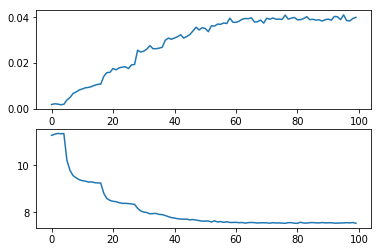

In [22]:
plt.subplot(211)
plt.plot(train_history)
plt.subplot(212)
plt.plot(loss_history);

# Визуализируем вектора для разного вида слов до и после тренировки

В случае успешной тренировки вы должны увидеть как вектора слов разных типов (например, знаков препинания, предлогов и остальных) разделяются семантически.

Студенты - в качестве выполненного задания присылайте notebook с диаграммами!

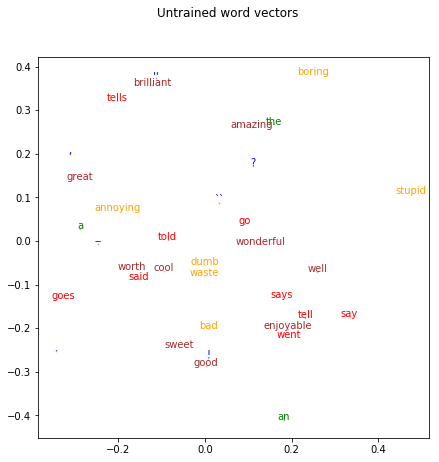

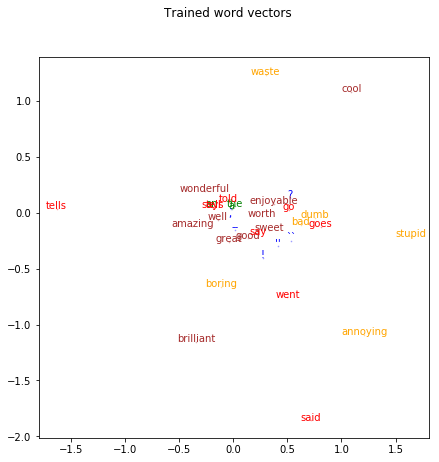

In [23]:
trained_input_vectors, trained_output_vectors = extract_word_vectors(nn_model)
assert trained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert trained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

visualize_vectors(data, untrained_input_vectors, untrained_output_vectors, 'cat', plt, "Untrained word vectors")
visualize_vectors(data, trained_input_vectors, trained_output_vectors, 'cat', plt, "Trained word vectors")